In [1]:
import numpy as np
import theano 
import theano.tensor as T


import IPython
import matplotlib.pyplot as plt
import timeit

%pylab inline
pylab.rcParams['figure.figsize'] = (6, 4)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using gpu device 0: GeForce GTX 670MX (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5105)


Populating the interactive namespace from numpy and matplotlib


# Régression Logistique 

* Classifieur linéaire 
* $ x^{i} = (x_{1}, x{_2}, ..., x_{m}) $ le vecteur (ligne) d'entrée (nos données), une image par exemple
* Paramètres : une matrice $ W $ et un vecteur ligne $ b $  (ici $\theta = ( \ W \ , \ b \ )$)
* $ y^{i} \in \{1 , 2, ..., K\}$ , $K$ classes possibles ! 

$$ \begin{align} 
P(Y=i|x, W,b) &= softmax_i(x W + b) \\
& = \frac{e^{ x W_i + b_i}}{\sum_j e^{x W_j + b_j}}
\end{align}$$


![Softmax function](../resources/softmax.png )


On pour un vecteur d'entrée $x$, connaissant les poids $W$ et $b$ : 
$$y_{pred} = argmax_i P(Y=i|x,W,b)$$



Pour plusieurs images, on définit la fonction de coût comme : 
$$ E(X,Y,\theta) = - \sum_{i=1}^N log( P(Y=y^{(i)}|x^{(i)}, \theta) ) $$

# Mini-batches Stochastic Gradient Descent 

On ne vas pas calculer l'erreur sur tout le dataset, mais seulement sur un mini-batch de données, c'est à dire quelques exemples (~ 100). 

On va donc avoir un entrainement de la forme : 

In [2]:
#nos données 
X = ....
Y = ....
batch_size = ...

n_train_batches = X.shape[0] // batch_size

for epoch in range(n_epochs):
    
    for index in range(n_train_batches):
        
        X_batch = X[index*batch_size : (index+1)*batch_size]
        Y_batch = Y[index*batch_size : (index+1)*batch_size]
        loss = f(params, X_batch, Y_batch)
        grad_loss_wrt_params = T.grad(.....)
        
        params = params - learning_rate * d_loss_wrt_params
            

SyntaxError: invalid syntax (<ipython-input-2-bf4dac6d4fc7>, line 2)

**Intérêts de la descente du gradient par mini-batch :**
* 
* 
* 


# Digit Recognizer : classification de carractères manuscrits 

In [3]:
## Données d'entrainement, de validation et de test (labels inconnus)
X_train = np.load('../data/digit-recognizer/X_train.npy')
X_valid = np.load('../data/digit-recognizer/X_valid.npy')
X_test = np.load('../data/digit-recognizer/X_test.npy')

## Les labels 
Y_train = np.load('../data/digit-recognizer/y_train.npy')
Y_valid = np.load('../data/digit-recognizer/y_valid.npy')

print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape)

((37000, 784), (5000, 784), (28000, 784))
((37000,), (5000,))


---------------------------------------
Les images sont déjà sous forme de vecteur 28*28 = 784. 

37,000 données d'entrainement

5,000 données de validation, pour mesurer les performances du classifieur 

28,000 données à labeliser ! 

images 28 x 28

----------------------------------------

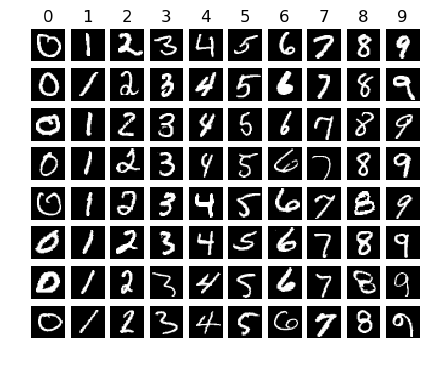

In [4]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)
samples = 8

for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in Y_train])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((28, 28)))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
        

plt.show()

# Régression Logistique avec Theano

### Créer des variables paratgées (shared variables) pour les données 

Accélère l'entrainement par mini-batch ! 

In [5]:
X_train_shared =  T.cast(theano.shared(X_train, borrow=True),'float32')
Y_train_shared = T.cast(theano.shared(Y_train, borrow=True),'int32')

### Paramètres de l'apprentissage

In [6]:
learning_rate=0.05
n_epochs=1000
batch_size=256

n_train_batches = X_train.shape[0] // batch_size

# nb de pixels
n_in = 28*28

#nb de classes
n_out = 10

### Construction du modèle 

Besoin de 3 variables symboliques : 
* index, qui représente le numéro du batch en cours pendant l'entrainemen
* X, qui représente nos données, sous forme d'une matrice -> **une ligne = une image**
* Y, qui repésente nos labels, sous forme d'un vecteur d'entiers 


Astuces : 
Il existe de nombreux types de variables symboliques !

`T.scalar(), T.matrix(), T.vector()`

et les variantes avec i et l, pour `int` et `long`

`T.iscalar(), T.lscalar(), ..`


In [7]:
index = T.lscalar('index')
X = T.matrix('X')
Y = T.ivector('Y')


Paramètres entrainables : W et b
Qui sont des variables partagées !

Astuce pour créer une variable partagée : 

``` var = theano.shared( value = var_init, name='var', borrow=True)```

Où `var_init` est un tableau `numpy.ndarray` avec `dtype = ... `

In [8]:
W_init = np.zeros( (n_in, n_out), dtype=theano.config.floatX )
W = theano.shared( value = W_init)


In [9]:
b_init = np.zeros( (n_out), dtype=theano.config.floatX )
b = theano.shared(value = b_init) 

On peut maintenant définir $P(Y=i|x, W,b)$ et $y_{pred}$

Rappels : 
`theano.tensor` contient certainement toutes les fonctions nécessaires ! 
Certaines, qui sont spécifiques aux réseaux de neuronnes se trouvent dans `theano.tensor.nnet`

Attention : `*` ne correspond pas au produit matriciel ! 


Caisse à outils : 
```
T.dot(A,B)
T.argmin(A,axis=...) , T.argmax(A,axis=...)
T.nnet.softmax(A)
T.mean(A) -> Si A est un vecteur, T.mean retourne une variable symbolique scalaire 
T.neq(r,t)
T.log()
T.arange()
```


In [10]:
# une matrice, où le i-eme vecteur ligne est de taille K et correspond aux probabilités que l'image de la ligne i
# de la matrice X appartiennent aux K classes !
p_y_given_x = T.nnet.softmax(T.dot(X, W) + b)

# un vecteur colonne, où l'élément i correspond à la classe prédite pour l'image de la ligne i de la matrice X ! 
y_pred = T.argmax(p_y_given_x, axis=1)

In [11]:
# variable symbolique scalaire, comprise entre 0 et 1, correspondant au taux d'erreur de prédiction
# pour les images de la matrice X
errors = T.mean(T.neq(y_pred, Y))

In [12]:
# Variable symbolique scalaire
# - log-vraisemblance 
# première étape : matrice log-probabilité 

LP = T.log(p_y_given_x)

# ne garder que les log-probabilités voulues : 

cost = cost = -T.mean(LP[T.arange(Y.shape[0]), Y])

Pour rappel : 
$$ E(X,Y,\theta) = - \sum_{i=1}^N log( P(Y=y^{(i)}|x^{(i)}, \theta) ) $$

In [13]:
# Petit rappel Numpy : 

#### On peut passer à la compilation de différentes fonctions 

- Une fonction pour évaluer le modèle, `validation_model`, qui devra calculer le taux d'erreur sur les données de validation 

- Une fonction pour appliquer le modèle, `test_model`, qui va prédire les classes pour chaque image sur les données de test

In [14]:
validation_model = theano.function(
        inputs=[X,Y],
        outputs= errors
    )



test_model = theano.function(
        inputs=[X],
        outputs= y_pred
    )



On calcule les gradients selon les paramètres du système :

In [15]:
g_W = T.grad(cost, W)
g_b = T.grad(cost, b)
  
updates = [(W, W - learning_rate * g_W),
               (b, b - learning_rate * g_b)]

La fonction `train_model`, calcul le coût (- log-vraisemblance) du mini-batch d'indice `index`, et met à jour à les paramètres $W$ et $b$ : 

In [ ]:
train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            X: X_train_shared[index * batch_size: (index + 1) * batch_size],
            Y: Y_train_shared[index * batch_size: (index + 1) * batch_size]
        }
    )

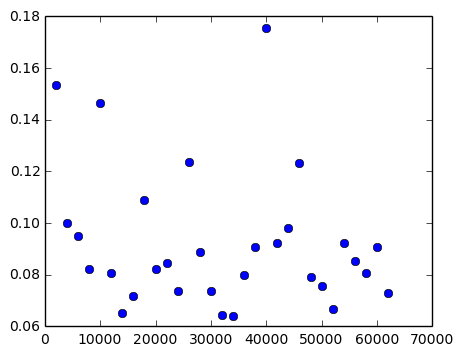

In [ ]:
best_validation_loss = np.inf
validation_frequency = 2000

start_time = timeit.default_timer()
for epoch in range(n_epochs):
    for minibatch_index in range(n_train_batches):
        
        minibatch_avg_cost = train_model(minibatch_index)
            
        # iteration number
        iter = (epoch) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            this_validation_loss = validation_model(X_valid,Y_valid.astype('int32'))

            pylab.plot([iter], [this_validation_loss], 'bo', label='validation_loss')
            IPython.display.clear_output(wait=True)
            IPython.display.display(pylab.gcf())
        
            
            if this_validation_loss < best_validation_loss:
                best_validation_loss = this_validation_loss

end_time = timeit.default_timer()

print(( 'Entrainement fini : %f %%') % (best_validation_loss * 100.))
    
print('en %d secondes, avec %f epochs/sec' % ((end_time - start_time), 1. * epoch / (end_time - start_time)))

On peut maintenant passer à la prédiction : 

In [ ]:
plt.imshow(X_test[5].reshape(28,28))

In [ ]:
test_model(X_test[5].reshape(1,784))

In [ ]:
predictions = test_model(X_test)
predictions

In [ ]:
# Pour écrire le fichier .csv pour soumettre ses résultats sur Kaggle ! 

out_file = open("predictions_DIGIT-RECOGNIZER.csv", "w")
out_file.write("ImageId,Label\n")
for i in range(len(predictions)):
    out_file.write(str(i+1) + "," + str(int(predictions[i])) + "\n")
out_file.close()
    